In [1]:
import torch
import torch.nn   
import torch.optim
import torch.nn.functional 
import torchvision.datasets  
import torchvision.transforms   


from torch.autograd import Variable
from torch.nn import Linear, ReLU, CrossEntropyLoss, Sequential, Conv2d, MaxPool2d, Module, Softmax, BatchNorm2d, Dropout
from torch.optim import Adam, SGD

import numpy as np 
from matplotlib import pyplot 
from matplotlib.pyplot import subplot     
from sklearn.metrics import accuracy_score
import re
import glob
import cv2

from scipy.ndimage.interpolation import zoom
import pandas as pd
import numpy as np
import random
%matplotlib inline

In [2]:
labels = pd.read_excel("BDRW_train_data/labels.xls",header=None)
labels.columns = ['digit', 'label']

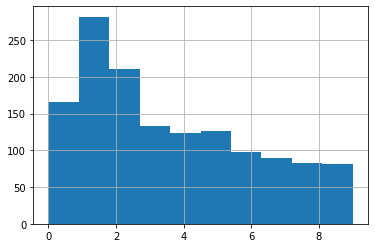

In [3]:
labels.label.hist()

In [4]:
image_list = []
size = 32
numbers = re.compile(r'(\d+)')
def Sort(value):
    parts = numbers.split(value)
    parts[1::2] = map(int, parts[1::2])
    return parts
for filename in sorted(glob.glob("BDRW_train_data/*.jpg"), key=Sort):
    im=cv2.imread(filename, 0)
    im=cv2.resize(im, (size, size))
    image_list.append(np.array(im))
    
input_data = np.array(image_list)
input_data= (input_data)/float(256) - 0.5
outputs = labels.iloc[:,1:].values

print('input_data shape: ',input_data.shape)

input_data shape:  (1393, 32, 32)


In [5]:
#shuffle input to handle class imbalance
indices = np.arange(input_data.shape[0])
np.random.shuffle(indices)
input_data = input_data[indices]
outputs = outputs[indices]

input_data = input_data.reshape(input_data.shape[0], 1, size, size)
train_x = input_data[:int(0.8*len(input_data))]
train_x  = torch.from_numpy(train_x)
train_y = outputs[:int(0.8*len(outputs))]
train_y = torch.from_numpy(train_y)
train_y = train_y.squeeze()

val_x = input_data[int(0.8*len(input_data)):int(0.90*len(input_data))]
val_x  = torch.from_numpy(val_x)
val_y = outputs[int(0.8*len(outputs)):int(0.90*len(outputs))]
val_y = torch.from_numpy(val_y)
val_y = val_y.squeeze()

test_x = input_data[int(0.90*len(input_data)):]
test_x  = torch.from_numpy(test_x)
test_y = outputs[int(0.90*len(outputs)):]

In [6]:
class Net(torch.nn.Module):
     
    def __init__(self):   
        super(Net, self).__init__()
        self.conv1 = torch.nn.Conv2d(in_channels=1, out_channels=6, kernel_size=5, stride=1, padding=2, bias=True)
        self.max_pool_1 = torch.nn.MaxPool2d(kernel_size=2)
        self.conv2 = torch.nn.Conv2d(in_channels=6, out_channels=16, kernel_size=5, stride=1, padding=0, bias=True)
        self.max_pool_2 = torch.nn.MaxPool2d(kernel_size=2)
        self.fc1 = torch.nn.Linear(24*24, 120)   
        self.fc2 = torch.nn.Linear(120, 84)      
        self.fc3 = torch.nn.Linear(84, 10)        
        
    def forward(self, x):
        x = torch.nn.functional.relu(self.conv1(x))  
        x = self.max_pool_1(x)
        x = torch.nn.functional.relu(self.conv2(x))
        x = self.max_pool_2(x)
        x = x.view(-1, 24*24)
        x = torch.nn.functional.relu(self.fc1(x))
        x = torch.nn.functional.sigmoid(self.fc2(x))
        x = self.fc3(x)
        
        return x
     


In [7]:
model = Net()
optimizer = Adam(model.parameters(), lr=0.0045)
criterion = CrossEntropyLoss()

In [8]:
def train(epoch):
    model.train()
    tr_loss = 0
    x_train, y_train = Variable(train_x), Variable(train_y)
    x_val, y_val = Variable(val_x), Variable(val_y)

    optimizer.zero_grad()
    
    output_train = model(x_train.float())
    output_val = model(x_val.float())

    loss_train = criterion(output_train, y_train)
    loss_val = criterion(output_val, y_val)
    train_losses.append(loss_train)
    val_losses.append(loss_val)

    loss_train.backward()
    optimizer.step()
    tr_loss = loss_train.item()
    if epoch%1 == 0:
        print('Epoch : ',epoch+1, '\t', 'running_loss :', loss_val.clone().item())

In [9]:
n_epochs = 90
train_losses = []
val_losses = []
for epoch in range(n_epochs):
    train(epoch)

C:\Users\ishu jatav\anaconda3\lib\site-packages\torch\nn\functional.py:1351: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


Epoch :  1 	 running_loss : 2.292116641998291
Epoch :  2 	 running_loss : 2.2254204750061035
Epoch :  3 	 running_loss : 2.2273426055908203
Epoch :  4 	 running_loss : 2.246332883834839
Epoch :  5 	 running_loss : 2.237722158432007
Epoch :  6 	 running_loss : 2.21921968460083
Epoch :  7 	 running_loss : 2.1994662284851074
Epoch :  8 	 running_loss : 2.1801984310150146
Epoch :  9 	 running_loss : 2.158424139022827
Epoch :  10 	 running_loss : 2.1309754848480225
Epoch :  11 	 running_loss : 2.0968141555786133
Epoch :  12 	 running_loss : 2.0558578968048096
Epoch :  13 	 running_loss : 2.0078799724578857
Epoch :  14 	 running_loss : 1.961012601852417
Epoch :  15 	 running_loss : 1.9207500219345093
Epoch :  16 	 running_loss : 1.8802096843719482
Epoch :  17 	 running_loss : 1.8276610374450684
Epoch :  18 	 running_loss : 1.7684590816497803
Epoch :  19 	 running_loss : 1.7141313552856445
Epoch :  20 	 running_loss : 1.6603624820709229
Epoch :  21 	 running_loss : 1.6066820621490479
Epoch : 

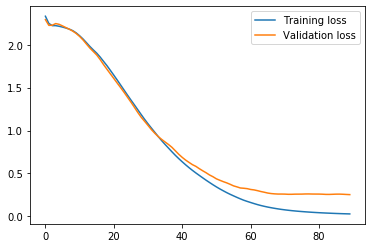

In [11]:
pyplot.plot(train_losses, label='Training loss')
pyplot.plot(val_losses, label='Validation loss')
pyplot.legend()
pyplot.show()

In [12]:
output = model(test_x.float())
softmax = torch.exp(output)
prob = list(softmax.detach().numpy())
predictions = np.argmax(prob, axis=1)
correct = 0
for i in range(len(test_y)):
    if test_y[i] == predictions[i]:
        correct = correct + 1
        
print("Accuracy: " + str(correct/len(test_y)))

C:\Users\ishu jatav\anaconda3\lib\site-packages\torch\nn\functional.py:1351: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


Accuracy: 0.9285714285714286
